In [2]:
import numpy as np

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
import seaborn as sns

## Generate Data
100 points with two features x1, x2.

y is a binary label -1, 1

x0 is the bias term

prediction = x1\*w1 + x2\*w2 + x3\*w3

In [110]:
x0 = np.ones(100) 
x1 = np.random.normal(0, 1, 100)
x2 = np.random.normal(0, 1, 100)

In [111]:
#y = np.random.randint(2, size=100) * 2 - 1

In [112]:
0.1 * np.random.random_sample()

0.04315057730734071

In [113]:
y = np.array([1 if x else -1 for x in x1 < (x2 * 2 + 2 * np.random.random_sample() - 1)])

In [114]:
y

array([-1,  1, -1, -1, -1,  1, -1, -1,  1,  1, -1, -1, -1, -1,  1, -1,  1,
        1,  1,  1,  1, -1,  1,  1, -1, -1, -1, -1, -1,  1,  1,  1, -1, -1,
        1,  1,  1, -1, -1, -1,  1, -1,  1, -1, -1,  1, -1, -1,  1,  1,  1,
       -1,  1,  1,  1, -1,  1, -1, -1,  1,  1, -1, -1,  1, -1,  1,  1,  1,
       -1,  1,  1,  1,  1,  1, -1, -1, -1, -1,  1, -1,  1, -1,  1, -1, -1,
       -1,  1, -1,  1,  1, -1, -1,  1, -1,  1,  1, -1, -1, -1, -1])

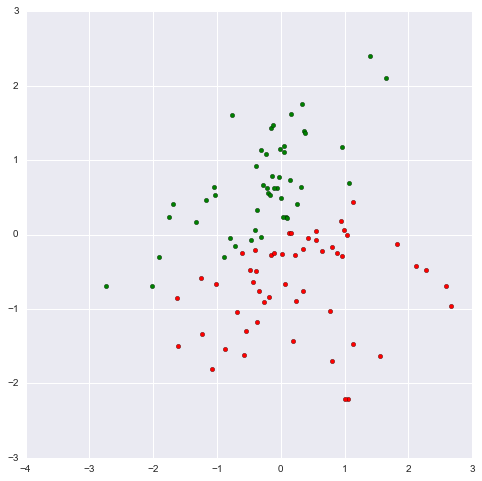

In [115]:
plt.figure(figsize=(8, 8))
plt.scatter(x1[y==1], x2[y==1], c='g')
plt.scatter(x1[y==-1], x2[y==-1], c='r')

In [116]:
X = np.array([x0, x1, x2])

In [187]:
X = np.array([x1, x2])

In [188]:
X = X.T

In [363]:
vfunc = np.vectorize(lambda x: x+1)

In [364]:
vfunc(np.array([[2, 5], [3, 4]]))

array([[3, 6],
       [4, 5]])

## Something about the function and derivative

In [470]:
def hinge_op(x):
    return 0 if x > 1 else 1 - x

def hinge(X, y, w):
    return 1.0 / len(y) * sum(list(map(lambda x: hinge_op(x), y * np.dot(X, w))))

def hinge_diff_op(t):
    return 0 if t > 1 else -1

def hinge_diff(X, y, w):
    t_diff = np.array(list(map(lambda a: hinge_diff_op(a), y * np.dot(X, w))))
    return 1.0 / len(y) * np.sum(np.apply_along_axis(lambda col: col * y * t_diff, 0, X), axis=0)

def hinge_subdiff(X, y, w):
    rule = 1 - y * np.dot(X, w) > 0
    return -1.0 / len(y) * np.sum(X[rule] * np.array([y[rule]]).T, axis=0)

def moreau_op(z, n):
    if z > 1:
        return 0
    elif z >= 1 - n:
        return 1.0 / (2 * n) * (1 - z) ** 2
    else:
        return -n / 2 + 1 - z

def moreau(X, y, w, n):
    return 1.0 / len(y) * sum(list(map(lambda x : moreau_op(x, n), y * np.dot(X, w))))
    
def moreau_diff_op(z, n):
    if z > 1:
        return 0
    elif z >= 1 - n:
        return (z - 1.0) / n
    else:
        return -1
    
def moreau_diff(X, y, w, n):
    t_diff = np.array(list(map(lambda a: moreau_diff_op(a, n), y * np.dot(X, w))))
    return 1.0 / len(y) * np.sum(np.apply_along_axis(lambda col: col * y * t_diff, 0, X), axis=0)
    
def l2_norm(w, lam):
    return lam * (np.linalg.norm(w, 2) ** 2)

def l2_diff(w, lam):
    return 2 * lam * w

def l2_norm_prox(z, lam, nt):
    return z / (1 + 2 * lam * nt)

def svm_l2(X, y, w, lam):
    return hinge(X, y, w) + l2_norm(w, lam)

def svm_l2_subgradient(X, y, w, lam):
    return hinge_subdiff(X, y, w) + l2_diff(w, lam)

def svm_moreau_l2(X, y, w, n, lam):
    return moreau(X, y, w, n) + l2_norm(w, lam)
#def svm_dual(X, y, w,):

## Subgradient Algorithm

In [314]:
def subgradient(X, y, w, lam, iter_num):
    result = []
    for t in range(1, iter_num): 
        # choose dt
        dt = hinge_subdiff(X, y, w)
        
        # normalize
        dt = dt / np.linalg.norm(dt, 2)

        # choose step size
        nt = 0.2 / t
        w = l2_norm_prox(w - nt * dt, lam, nt)
        
        # record function value
        result.append(svm_l2(X, y, w, lam))
    return w, result

In [603]:
iter_num = 10000
lam = 0.1
weight1, result1 = subgradient(X, y, np.ones(2), lam, iter_num)

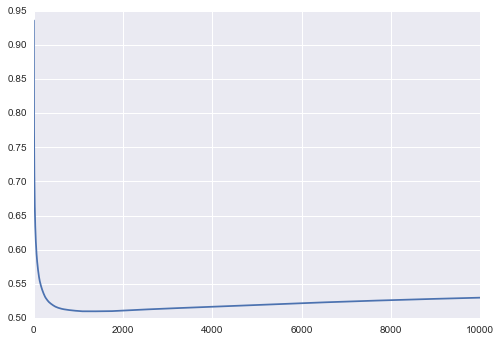

In [604]:
plt.plot(result1)

In [345]:
print(weight1)

[-0.68475857  1.53606085]
[-0.71459868  1.44025763]


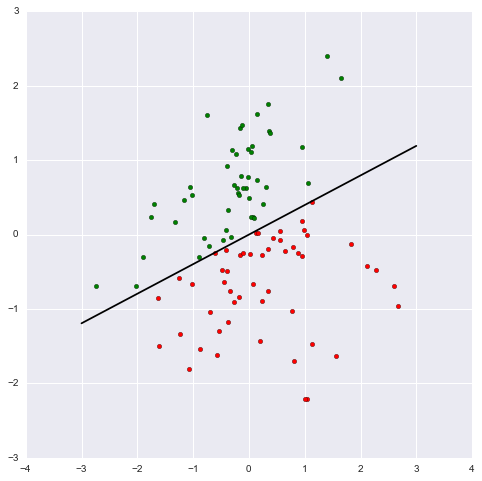

In [331]:
w = weight1
plt.figure(figsize=(8, 8))
plt.scatter(x1[y==1], x2[y==1], c='g')
plt.scatter(x1[y==-1], x2[y==-1], c='r')
a = -w[0] / w[1]
xx = np.linspace(-3, 3)
yy = a * xx
plt.plot(xx, yy, 'k-')

## Nesterov's dual averaging algorithm

In [246]:
def Nesterov(X, y, w, lam, gamma, iter_num):
    result = []
    st = np.zeros(w.shape[0])
    beta = 1
    for t in range(0, iter_num):
        # choose an arbitrary subgradient
        dt = svm_l2_subgradient(X, y, w, lam)
        st = st + dt
        w = -st / (2 * gamma * beta)
        beta = beta + 1.0 / beta
        result.append(svm_l2(X, y, w, lam))
    return w, result

In [338]:
iter_num = 1000
lam = 0.1
gamma = 0.1
weight1, result1 = Nesterov(X, y, np.ones(2), lam, gamma, iter_num)

In [341]:
print(weight1)

[-0.47660549  1.06399745]
[-0.47660549  1.06399745]


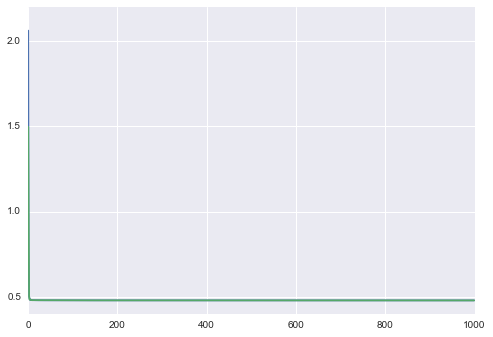

In [342]:
plt.plot(result1)

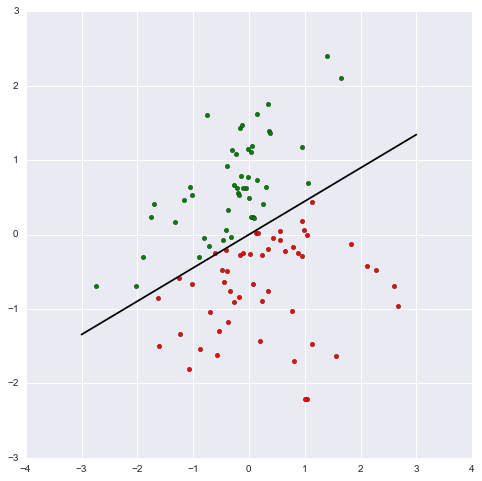

In [327]:
w = weight1
plt.figure(figsize=(8, 8))
plt.scatter(x1[y==1], x2[y==1], c='g')
plt.scatter(x1[y==-1], x2[y==-1], c='r')
a = -w[0] / w[1]
xx = np.linspace(-3, 3)
yy = a * xx
plt.plot(xx, yy, 'k-')

## SVM Dual problem

In [503]:
def SVM_dual(X, y, a, lam):
    two_sum = 0
    for i in range(0, len(y)):
        for j in range(0, len(y)):
            two_sum += a[i] * a[j] * y[i] * y[j] * np.dot(X[i], X[j])
    return -sum(a) + 1.0/(4 * lam) * two_sum

def SVM_dual_diff(X, y, a, i, lam):
    sum_result = 0
    for j in range(0, len(y)):
        sum_result += 1/(2 * lam) * y[i] * np.dot(X[i], a[j] * y[j] * X[j])
    return -1 + sum_result

In [543]:
def dual_proximal(X, y, a, n, lam, iter_num):
    result = []
    for t in range(0, iter_num):
        l_diff = np.array([SVM_dual_diff(X, y, a, i, lam) for i in range(0, len(y))])
        z = a - n * l_diff
        a_pre = a
        # proximal mapping becomes identity mapping
        a = z
        
        # backtracking the step size
        while (SVM_dual(X, y, a, lam) > SVM_dual(X, y, a_pre, lam) + np.dot(a - a_pre, l_diff) + 
               1.0 / (2 * n) * (np.linalg.norm(a - a_pre, 2) ** 2)):
            n = n / 2
            w = z
        result.append(SVM_dual(X, y, a, lam))
    return a, result

In [544]:
iter_num = 200
n = 1e-4
lam = 0.1
weight1, result1 = dual_proximal(X, y, np.ones(len(y)), n, lam, iter_num)

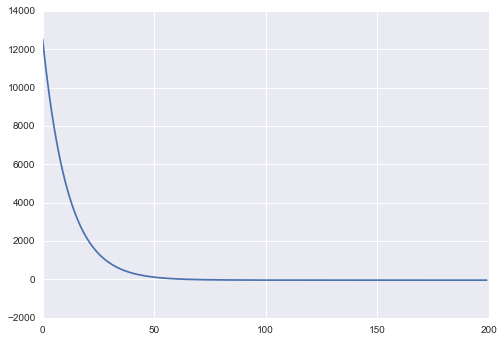

In [545]:
plt.plot(result1)

## Accerated dual proximal

In [548]:
import math
def dual_acceleratedProximal(X, y, a, n, lam, iter_num):
    result = []
    u = a
    gamma = 1
    for t in range(1, iter_num):
        l_diff = np.array([SVM_dual_diff(X, y, u, i, lam) for i in range(0, len(y))])
        z = u - n * l_diff
        a_pre = a
        a = z
        
        # backtracking the step size
        while (SVM_dual(X, y, a, lam) > SVM_dual(X, y, u, lam) + np.dot(a - u, l_diff) + 
               1.0 / (2 * n) * (np.linalg.norm(a - u, 2) ** 2)):
            n = n / 2
            a = u - n * l_diff
        
        # enforcing descending
        if SVM_dual(X, y, a, lam) > SVM_dual(X, y, a_pre, lam):
            a = a_pre
            
        gamma_pre = gamma
        gamma = (1 + math.sqrt(1 + 4 * gamma ** 2)) / 2
        
        # extrapolation
        u = a + (gamma_pre - 1) / gamma * (a - a_pre)
        
        result.append(SVM_dual(X, y, a, lam))
    return a, result

In [546]:
iter_num = 200
n = 1e-4
lam = 0.1
weight1, result1 = dual_acceleratedProximal(X, y, np.ones(len(y)), n, lam, iter_num)

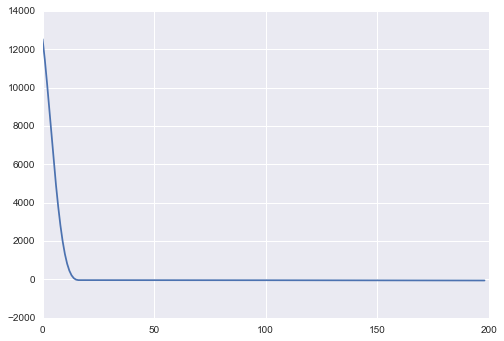

In [547]:
plt.plot(result1)

## Proximal Gradient

In [471]:
def proximal(X, y, w, n, lam, iter_num):
    result = []
    for t in range(0, iter_num):
        l_diff = moreau_diff(X, y, w, n)
        z = w - n * l_diff
        w_pre = w
        w = l2_norm_prox(z, lam, n)
        
        # backtracking the step size
        while (moreau(X, y, w, n) > moreau(X, y, w_pre, n) + np.dot(w - w_pre, l_diff) + 
               1.0 / (2 * n) * (np.linalg.norm(w - w_pre, 2) ** 2)):
            n = n / 2
            w = l2_norm_prox(z, lam, n)
        result.append(svm_moreau_l2(X, y, w, n, lam))
    return w, result

In [480]:
iter_num = 60000
n = 1e-4
lam = 0.1
weight1, result1 = proximal(X, y, np.ones(2), n, lam, iter_num)

In [481]:
print(weight1)

[-0.45731268  1.07945508]


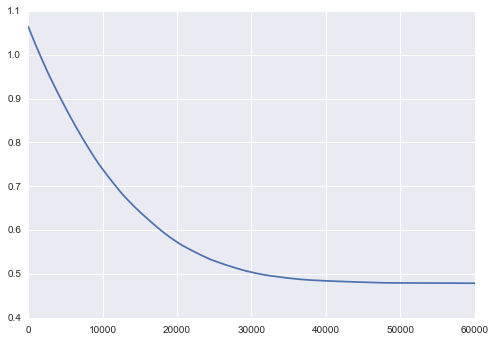

In [482]:
plt.plot(result1)

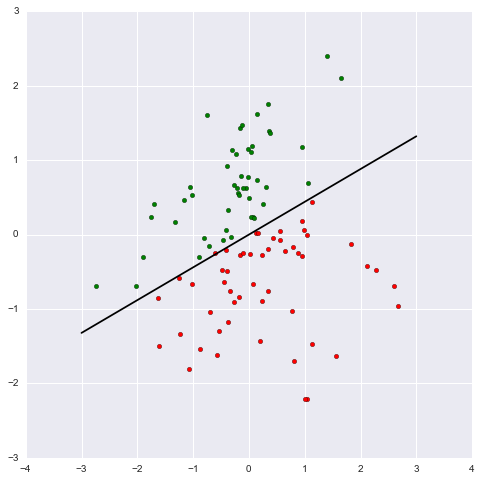

In [479]:
w = weight1
plt.figure(figsize=(8, 8))
plt.scatter(x1[y==1], x2[y==1], c='g')
plt.scatter(x1[y==-1], x2[y==-1], c='r')
a = -w[0] / w[1]
xx = np.linspace(-3, 3)
yy = a * xx
plt.plot(xx, yy, 'k-')

## Accelerated Proximal gradient. FISTA

In [570]:
import math
def acceleratedProximal(X, y, w, n, lam, iter_num):
    result = []
    u = w
    gamma = 1
    for t in range(1, iter_num):
        l_diff = moreau_diff(X, y, u, n)
        z = u - n * l_diff
        w_pre = w
        w = l2_norm_prox(z, lam, n)
        
        # backtracking the step size
        while (moreau(X, y, w, n) > moreau(X, y, u, n) + np.dot(w - u, l_diff) + 
               1.0 / (2 * n) * (np.linalg.norm(w - u, 2) ** 2)):
            n = n / 2
            w = l2_norm_prox(u - n * l_diff, lam, n)
        
        # enforcing descending
        if svm_moreau_l2(X, y, w, n, lam) > svm_moreau_l2(X, y, w_pre, n, lam):
            w = w_pre
            
        gamma_pre = gamma
        gamma = (1 + math.sqrt(1 + 4 * gamma ** 2)) / 2
        
        # extrapolation
        u = w + (gamma_pre - 1) / gamma * (w - w_pre)
        
        result.append(svm_moreau_l2(X, y, w, n, lam))
    return w, result

In [492]:
iter_num = 2000
n = 1e-4
lam = 0.1
weight1, result1 = acceleratedProximal(X, y, np.ones(2), n, lam, iter_num)

In [493]:
print(weight1)

[-0.4809002   1.08785862]


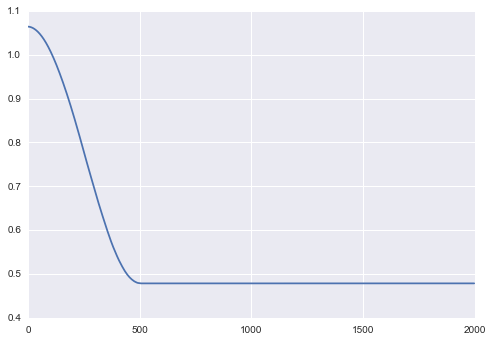

In [494]:
plt.plot(result1)

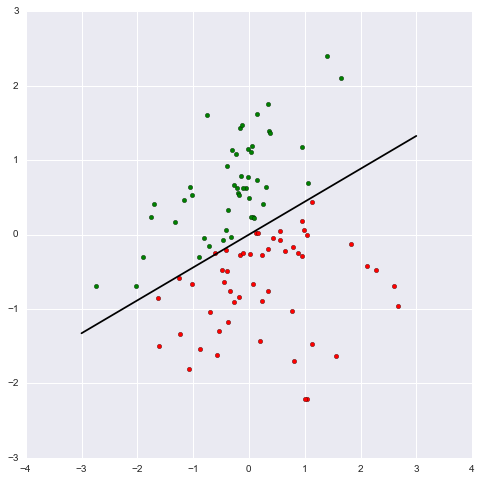

In [495]:
w = weight1
plt.figure(figsize=(8, 8))
plt.scatter(x1[y==1], x2[y==1], c='g')
plt.scatter(x1[y==-1], x2[y==-1], c='r')
a = -w[0] / w[1]
xx = np.linspace(-3, 3)
yy = a * xx
plt.plot(xx, yy, 'k-')

## Here we try LARGE problem with 100 dimentions, 1000 points

In [556]:
LARGE_X = np.random.normal(0, 1, (1000, 100))

In [558]:
LARGE_X.shape

(1000, 100)

In [559]:
LARGE_y = np.random.randint(2, size=1000) * 2 - 1

In [561]:
LARGE_y.shape

(1000,)

In [565]:
import time

iter_num = 10000
lam = 0.1

start_time = time.time()
weight1, result1 = subgradient(LARGE_X, LARGE_y, np.ones(100), lam, iter_num)
print(time.time() - start_time)

start_time = time.time()
gamma = 0.1
weight2, result2 = Nesterov(LARGE_X, LARGE_y, np.ones(100), lam, gamma, iter_num)
print(time.time() - start_time)

16.440515995025635
18.544925928115845


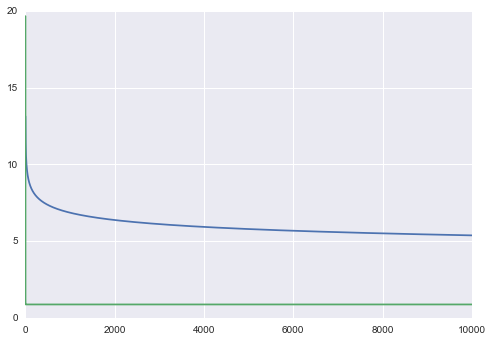

In [566]:
plt.plot(result1)
plt.plot(result2)

In [573]:
import time

iter_num = 1000
n = 1e-4
lam = 0.1

start_time = time.time()
weight3, result3 = proximal(LARGE_X, LARGE_y, np.ones(100), n, lam, iter_num)
print(time.time() - start_time)

start_time = time.time()
weight4, result4 = acceleratedProximal(LARGE_X, LARGE_y, np.ones(100), n, lam, iter_num)
print(time.time() - start_time)

9.541446685791016
13.747972011566162


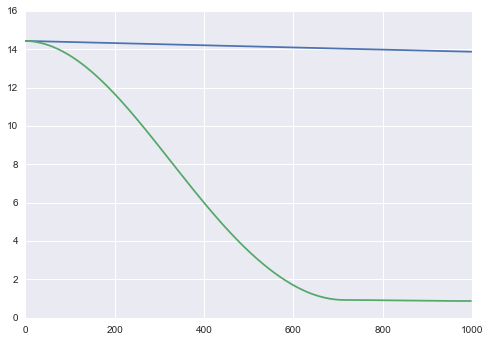

In [574]:
plt.plot(result3)
plt.plot(result4)

## SVM with l1 norm

In [587]:
def huber_op(z, n):
    if z > n:
        return z - n / 2
    elif z >= - n:
        return 1.0 / (2 * n) * z ** 2
    else:
        return -n / 2 - z

def huber(w, n):
    return lam * sum(list(map(lambda x : huber_op(x, n), w)))
    
def huber_diff_op(z, n):
    if z > n:
        return 1
    elif z >= - n:
        return z / n
    else:
        return -1
    
def huber_diff(w, n):
    return lam * np.array(list(map(lambda a: huber_diff_op(a, n), w)))

def SVM_smooth(X, y, w, n, lam):
    return moreau(X, y, w, n) + huber(w, lam)

def SVM_smooth_diff(X, y, w, n, lam):
    return moreau_diff(X, y, w, n) + huber_diff(w, lam)

In [591]:
def sparse_subgradient(X, y, w, n, lam, iter_num):
    result = []
    for t in range(1, iter_num): 
        # choose dt
        dt = SVM_smooth_diff(X, y, w, n, lam)
        
        # normalize
        dt = dt / np.linalg.norm(dt, 2)

        # choose step size
        nt = 0.2 / t
        w = w - nt * dt
        
        # record function value
        result.append(SVM_smooth(X, y, w, n, lam))
    return w, result

In [592]:
iter_num = 10000
lam = 0.1
n = 0.1
weight1, result1 = sparse_subgradient(X, y, np.ones(2), n, lam, iter_num)

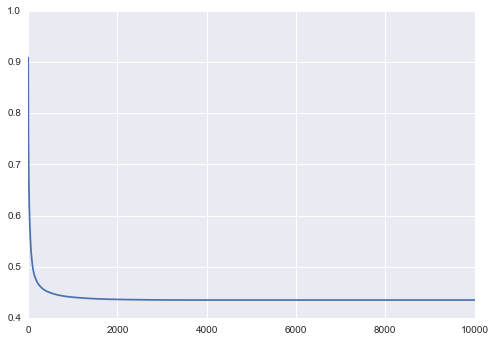

In [593]:
plt.plot(result1)

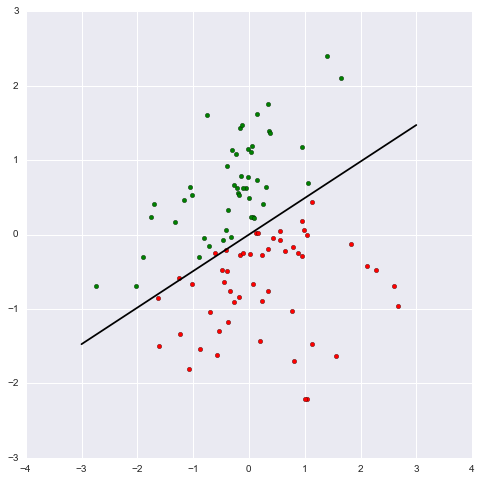

In [594]:
w = weight1
plt.figure(figsize=(8, 8))
plt.scatter(x1[y==1], x2[y==1], c='g')
plt.scatter(x1[y==-1], x2[y==-1], c='r')
a = -w[0] / w[1]
xx = np.linspace(-3, 3)
yy = a * xx
plt.plot(xx, yy, 'k-')

In [595]:
def sparse_proximal(X, y, w, n, lam, iter_num):
    result = []
    for t in range(0, iter_num):
        l_diff = SVM_smooth_diff(X, y, w, n, lam)
        z = w - n * l_diff
        w_pre = w
        w = z
        
        # backtracking the step size
        while (SVM_smooth(X, y, w, n, lam) > SVM_smooth(X, y, w_pre, n, lam) + np.dot(w - w_pre, l_diff) + 
               1.0 / (2 * n) * (np.linalg.norm(w - w_pre, 2) ** 2)):
            n = n / 2
            w = z
        result.append(SVM_smooth(X, y, w, n, lam))
    return w, result

In [596]:
iter_num = 60000
n = 1e-4
lam = 0.1
weight1, result1 = sparse_proximal(X, y, np.ones(2), n, lam, iter_num)

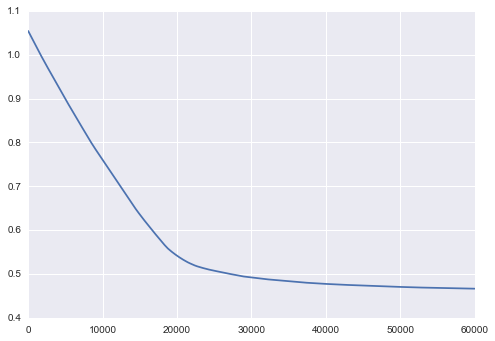

In [597]:
plt.plot(result1)

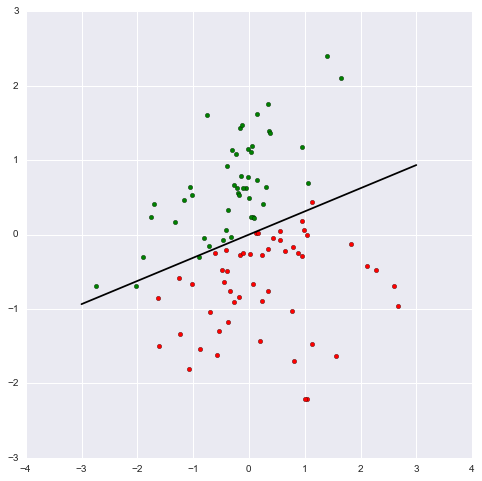

In [598]:
w = weight1
plt.figure(figsize=(8, 8))
plt.scatter(x1[y==1], x2[y==1], c='g')
plt.scatter(x1[y==-1], x2[y==-1], c='r')
a = -w[0] / w[1]
xx = np.linspace(-3, 3)
yy = a * xx
plt.plot(xx, yy, 'k-')

In [599]:
import math
def sparse_acceleratedProximal(X, y, w, n, lam, iter_num):
    result = []
    u = w
    gamma = 1
    for t in range(1, iter_num):
        l_diff = SVM_smooth_diff(X, y, w, n, lam)
        z = u - n * l_diff
        w_pre = w
        w = z
        
        # backtracking the step size
        while (SVM_smooth(X, y, w, n, lam) > SVM_smooth(X, y, u, n, lam) + np.dot(w - u, l_diff) + 
               1.0 / (2 * n) * (np.linalg.norm(w - u, 2) ** 2)):
            n = n / 2
            w = u - n * l_diff
        
        # enforcing descending
        if SVM_smooth(X, y, w, n, lam) > SVM_smooth(X, y, w_pre, n, lam):
            w = w_pre
            
        gamma_pre = gamma
        gamma = (1 + math.sqrt(1 + 4 * gamma ** 2)) / 2
        
        # extrapolation
        u = w + (gamma_pre - 1) / gamma * (w - w_pre)
        
        result.append(SVM_smooth(X, y, w, n, lam))
    return w, result

In [600]:
iter_num = 2000
n = 1e-4
lam = 0.1
weight1, result1 = sparse_acceleratedProximal(X, y, np.ones(2), n, lam, iter_num)

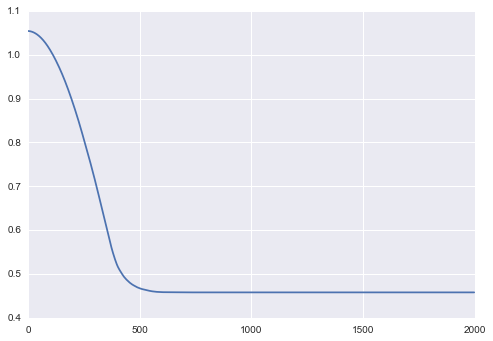

In [601]:
plt.plot(result1)

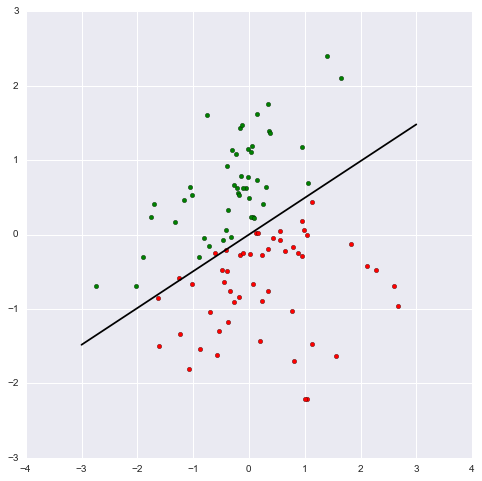

In [602]:
w = weight1
plt.figure(figsize=(8, 8))
plt.scatter(x1[y==1], x2[y==1], c='g')
plt.scatter(x1[y==-1], x2[y==-1], c='r')
a = -w[0] / w[1]
xx = np.linspace(-3, 3)
yy = a * xx
plt.plot(xx, yy, 'k-')